In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# first compute pred patches using challenge_conv1d.py, then postprocess with this notebook
data = np.load('tmp/pred_patches.npy', allow_pickle=True).item()

In [ ]:
print(data['casing'].keys())

dict_keys(['well_10_section_0_patch_0', 'well_10_section_0_patch_1', 'well_10_section_0_patch_2', 'well_10_section_0_patch_3', 'well_10_section_0_patch_4', 'well_10_section_0_patch_5', 'well_10_section_0_patch_6', 'well_10_section_0_patch_7', 'well_10_section_10_patch_0', 'well_10_section_10_patch_1', 'well_10_section_10_patch_2', 'well_10_section_10_patch_3', 'well_10_section_10_patch_4', 'well_10_section_10_patch_5', 'well_10_section_10_patch_6', 'well_10_section_10_patch_7', 'well_10_section_11_patch_0', 'well_10_section_11_patch_1', 'well_10_section_11_patch_2', 'well_10_section_11_patch_3', 'well_10_section_11_patch_4', 'well_10_section_11_patch_5', 'well_10_section_11_patch_6', 'well_10_section_11_patch_7', 'well_10_section_12_patch_0', 'well_10_section_12_patch_1', 'well_10_section_12_patch_2', 'well_10_section_12_patch_3', 'well_10_section_12_patch_4', 'well_10_section_12_patch_5', 'well_10_section_12_patch_6', 'well_10_section_12_patch_7', 'well_10_section_13_patch_0', 'well_1

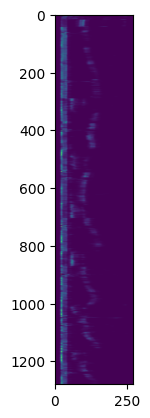

In [ ]:
# visualize
well = 10
section = 0
patch = 0
patches = []
while True:
    name = f'well_{well}_section_0_patch_{patch}'
    if name in data['tie']:
        patches.append(data['tie'][name])
        patch += 1
    else:
        break
patches = np.concatenate(patches, axis=0)
plt.imshow(patches)

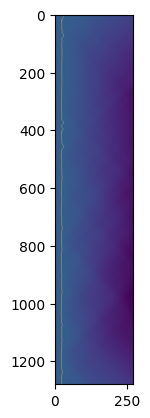

In [ ]:
# visualize score map
import torch
def compute_score_map(img, ball_size=3):
    """Compute score map, assume second dim is time"""
    assert ball_size % 2 == 1, "Ball size must be odd"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # build the terrain
    timg = torch.from_numpy(img)
    terrain = torch.cat(
        (torch.zeros(1, img.shape[1]), timg, torch.zeros(1, img.shape[1])), dim=0
    ).to(device)
    timg = timg.to(device)
    terrain_down = terrain.clone()
    terrain_up = terrain.clone()
    maxpool = torch.nn.MaxPool1d(ball_size, stride=1, padding=ball_size // 2)
    for row_ind in range(1, terrain.shape[0] - 1):  # forward
        # now the terrain has the max value that can be achieved from top to the current row
        terrain_down[row_ind] = (
            maxpool(terrain_down[row_ind - 1 : row_ind])[0] + terrain_down[row_ind]
        )
    for row_ind in range(terrain.shape[0] - 2, 0, -1):  # backward
        # now the terrain has the max value that can be achieved from bottom to the current row
        terrain_up[row_ind] = (
            maxpool(terrain_up[row_ind + 1 : row_ind + 2])[0] + terrain_up[row_ind]
        )
    terrain = (terrain_up + terrain_down)[
        1:-1
    ] - timg  # remove the padding and the original image$
    terrain = terrain / terrain.shape[0]  # mean node on path
    return terrain.cpu().numpy()

score_map = compute_score_map(patches)
plt.figure()
plt.imshow((score_map == np.max(score_map, axis=1, keepdims=True)) + score_map / score_map.max())

well_10_section_0
well_10_section_1
well_10_section_10
well_10_section_11
well_10_section_12
well_10_section_13
well_10_section_14
well_10_section_15
well_10_section_16
well_10_section_17
well_10_section_2
well_10_section_3
well_10_section_4
well_10_section_5
well_10_section_6
well_10_section_7
well_10_section_8
well_10_section_9
well_11_section_0
well_11_section_1
well_11_section_10
well_11_section_11
well_11_section_12
well_11_section_13
well_11_section_14
well_11_section_15
well_11_section_16
well_11_section_17
well_11_section_2
well_11_section_3
well_11_section_4
well_11_section_5
well_11_section_6
well_11_section_7
well_11_section_8
well_11_section_9
well_7_section_0
well_7_section_1
well_7_section_10
well_7_section_11
well_7_section_12
well_7_section_13
well_7_section_14
well_7_section_15
well_7_section_16
well_7_section_17
well_7_section_18
well_7_section_19
well_7_section_2
well_7_section_20
well_7_section_21
well_7_section_22
well_7_section_23
well_7_section_24
well_7_section_

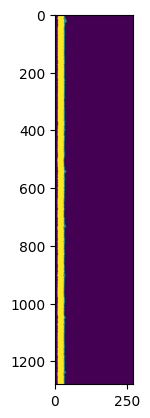

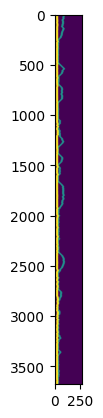

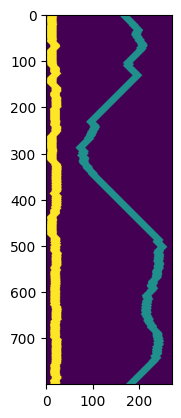

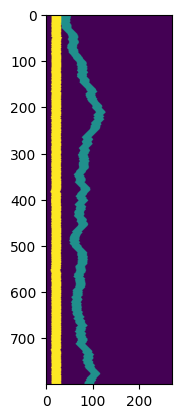

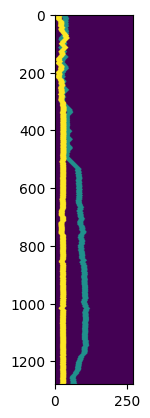

In [ ]:
# inference!
import pandas as pd
kernel_size = 21
wells = sorted(list(set([name.split('_')[1] for name in data['casing'].keys()])))
predictions = dict()
for well in wells:
    sections = sorted(list(set([name.split('_')[3] for name in data['casing'].keys() if f"well_{well}" in name])))
    for section in sections:
        print(f'well_{well}_section_{section}')
        patch = 0
        casings, ties = [], []
        while True:
            name = f"well_{well}_section_{section}_patch_{patch}"
            if name in data['casing']:
                casing = data['casing'][name]
                tie = data['tie'][name]
                casings.append(casing)
                ties.append(tie)
            else:
                break
            patch += 1
        casings = np.concatenate(casings, axis=0)
        ties = np.concatenate(ties, axis=0)

        casing_score = compute_score_map(casings)
        casing_line = casing_score == np.max(casing_score, axis=1, keepdims=True)
        
        tie_score = compute_score_map(ties)
        tie_line = tie_score == np.max(tie_score, axis=1, keepdims=True)

        out_label = np.clip(casing_line * 2 + tie_line * 1, min=0, max=2)
        out_label = torch.nn.MaxPool2d(kernel_size=(1, kernel_size), stride=1, padding=(0, kernel_size//2))(torch.from_numpy(out_label).float()[None, None])[0, 0]

        for patch_number in range(patch):
            patch_name = f"well_{well}_section_{section}_patch_{patch_number}"
            predictions[patch_name] = out_label[patch_number*160:(patch_number+1)*160, :].numpy().astype(int).flatten()

    plt.figure()
    plt.imshow(out_label)
print('saving...')
pd.DataFrame(predictions, dtype="int").T.to_csv('y_test_csv_file_line_21.csv')
print('saved!')